### Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import pandas as pd
from sklearn import metrics

import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

from config import *
from models import *
from masks import *
from utilities import *

Using TensorFlow backend.


### Load exmple model for predictions and 10 image names from training data

In [3]:
model = base_model(verbose=False)
model.load_weights(EXAMPLE_MODEL)

In [51]:
img_names = [f for f in os.listdir(TRAIN_IMG_PATH) if f.endswith('.tif')][:10]
len(img_names)

10

### Collected median results

In [80]:
results_median = pd.DataFrame(columns=['stride', 'time', 'ji', 'dice', 'img'])

k = 0 

for name_idx, name in enumerate(img_names):
    
    img = cv2.imread(TRAIN_IMG_PATH + name)[:320, :320, :]
    ground_truth = cv2.imread(TRAIN_MASK_PATH + name.rstrip('tif') + 'png', cv2.IMREAD_GRAYSCALE)[:320, :320]
    
    for i in range(0, 128, 32):
        stride = 128-i

        start_image = timer()
        result = collect_output_median(model, img, stride=stride)
        end_image = timer()

        mask = otsu_theshold(result)

        ji = metrics.jaccard_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))
        dice = metrics.f1_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))

        results_median.loc[k] = [stride, end_image-start_image, ji, dice, name]
        k += 1

results_median.to_csv(DUMPS_PATH + 'median.csv')

In [53]:
results_median.head(10)

,stride,time,ji,dice,img
0,128,5.983211,0.783104,0.878360,TCGA-G9-6348-01Z-00-DX1.tif
32,128,6.082817,0.765711,0.867312,TCGA-AY-A8YK-01A-01-TS1.tif
64,96,5.719009,0.769173,0.869528,TCGA-AY-A8YK-01A-01-TS1.tif
96,64,6.046678,0.766963,0.868115,TCGA-AY-A8YK-01A-01-TS1.tif
4,128,7.726480,0.717768,0.835699,TCGA-E2-A1B5-01Z-00-DX1.tif
36,128,5.668495,0.801917,0.890071,TCGA-38-6178-01Z-00-DX1.tif
68,96,5.662191,0.805287,0.892143,TCGA-38-6178-01Z-00-DX1.tif
100,64,6.321014,0.815716,0.898506,TCGA-38-6178-01Z-00-DX1.tif
8,128,6.606724,0.717378,0.835434,TCGA-CH-5767-01Z-00-DX1.tif
40,96,6.845959,0.726210,0.841392,TCGA-CH-5767-01Z-00-DX1.tif


In [83]:
results_median.describe()

,time,ji,dice
count,40.000000,40.000000,40.000000
mean,7.042455,0.767929,0.867960
std,1.287933,0.046711,0.030011
min,5.396151,0.684662,0.812818
25%,6.113379,0.725963,0.841226
50%,6.612360,0.771740,0.871166
75%,7.678988,0.791545,0.883644
max,11.910855,0.853298,0.920843


### Threshold voting results

In [54]:
results = pd.DataFrame(columns=['stride', 'time', 'ji', 'dice', 'img'])

k = 0 

for name in img_names:
    
    img = cv2.imread(TRAIN_IMG_PATH + name)[:320, :320, :]
    ground_truth = cv2.imread(TRAIN_MASK_PATH + name.rstrip('tif') + 'png', cv2.IMREAD_GRAYSCALE)[:320, :320]
    
    for i in range(0, 128, 32):
        stride = 128-i

        start_image = timer()
        result = collect_output_median(model, img, stride=stride, process_predicted_patch=otsu_theshold)
        end_image = timer()

        mask = np.zeros(result.shape, dtype='uint8')
        mask[result>0] = 255

        ji = metrics.jaccard_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))
        dice = metrics.f1_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))

        results.loc[k] = [stride, end_image-start_image, ji, dice, name]
        k += 1

results.to_csv(DUMPS_PATH + 'thresholded_median.csv')

In [55]:
results.head(10)

,stride,time,ji,dice,img
0,128,4.003283,0.787482,0.881107,TCGA-G9-6348-01Z-00-DX1.tif
1,96,3.720222,0.777214,0.874643,TCGA-G9-6348-01Z-00-DX1.tif
2,64,4.146309,0.790238,0.882830,TCGA-G9-6348-01Z-00-DX1.tif
3,32,5.678390,0.784938,0.879513,TCGA-G9-6348-01Z-00-DX1.tif
4,128,3.741433,0.699473,0.823164,TCGA-E2-A1B5-01Z-00-DX1.tif
5,96,3.573997,0.706178,0.827789,TCGA-E2-A1B5-01Z-00-DX1.tif
6,64,3.893832,0.699632,0.823275,TCGA-E2-A1B5-01Z-00-DX1.tif
7,32,5.319177,0.708228,0.829196,TCGA-E2-A1B5-01Z-00-DX1.tif
8,128,3.628316,0.715989,0.834491,TCGA-CH-5767-01Z-00-DX1.tif
9,96,3.540427,0.726988,0.841914,TCGA-CH-5767-01Z-00-DX1.tif


In [84]:
results.describe()

,time,ji,dice
count,40.000000,40.000000,40.000000
mean,4.020277,0.766305,0.866852
std,0.907809,0.048565,0.031379
min,3.079347,0.680178,0.809650
25%,3.457825,0.726718,0.841733
50%,3.609704,0.775458,0.873529
75%,4.321346,0.792613,0.884309
max,6.848751,0.852766,0.920533


### COMPARED (Threshold voting and collected median)

In [75]:
print(results_median['dice'].min())
print(results['dice'].min())
print(results_median['dice'].max())
print(results['dice'].max())

0.8128184459079225
0.8096499326502504
0.9208429383043218
0.9205326771368603


Text(0.5, 0.98, 'Dice on 10 train images with different strides')

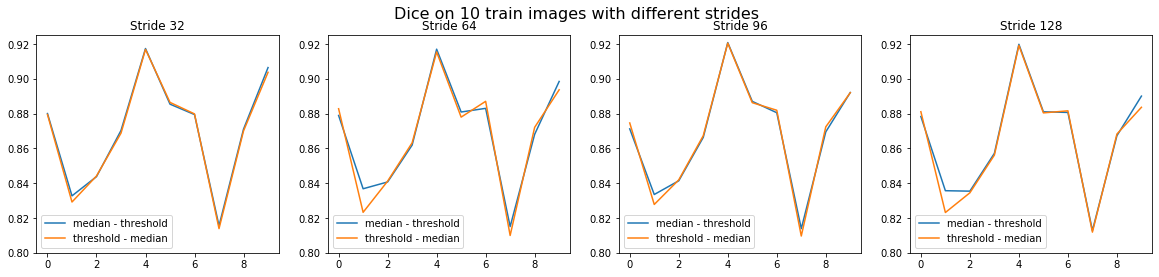

In [76]:
fig = plt.figure(figsize=(20,4))

ax = fig.add_subplot(1, 4, 1)
plt.plot(results_median[results_median['stride']==32]['dice'].tolist(), label = "median - threshold")
plt.plot(results[results['stride']==32]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 32')
ax.set_ylim([0.800, 0.925])

ax = fig.add_subplot(1, 4, 2)
plt.plot(results_median[results_median['stride']==64]['dice'].tolist(), label = "median - threshold")
plt.plot(results[results['stride']==64]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 64')
ax.set_ylim([0.800, 0.925])

ax = fig.add_subplot(1, 4, 3)
plt.plot(results_median[results_median['stride']==96]['dice'].tolist(), label = "median - threshold")
plt.plot(results[results['stride']==96]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 96')
ax.set_ylim([0.800, 0.925])

ax = fig.add_subplot(1, 4, 4)
plt.plot(results_median[results_median['stride']==128]['dice'].tolist(), label = "median - threshold")
plt.plot(results[results['stride']==128]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 128')
ax.set_ylim([0.800, 0.925])

fig.suptitle('Dice on 10 train images with different strides', fontsize=16)

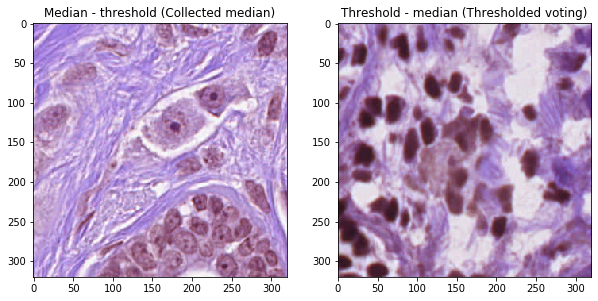

In [95]:
fig = plt.figure(figsize=(10,5))

img = cv2.imread(TRAIN_IMG_PATH + img_names[1])[:320, :320, :]
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img)
ax.title.set_text('Median - threshold (Collected median)')

img = cv2.imread(TRAIN_IMG_PATH + img_names[6])[:320, :320, :]
ax = fig.add_subplot(1, 2, 2)
plt.imshow(img)
ax.title.set_text('Threshold - median (Thresholded voting)')


#### COMPARED ON 3 TEST IMAGES

Text(0.5, 0.98, 'Dice on test images with different strides')

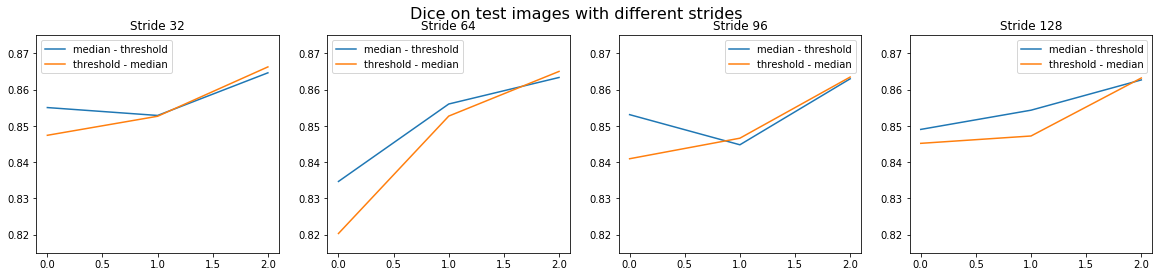

In [49]:
fig = plt.figure(figsize=(20,4))

ax = fig.add_subplot(1, 4, 1)
plt.plot(results_median[results_median['stride']==32]['dice'].to_list(), label = "median - threshold")
plt.plot(results[results['stride']==32]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 32')
ax.set_ylim([0.815, 0.875])

ax = fig.add_subplot(1, 4, 2)
plt.plot(results_median[results_median['stride']==64]['dice'].to_list(), label = "median - threshold")
plt.plot(results[results['stride']==64]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 64')
ax.set_ylim([0.815, 0.875])

ax = fig.add_subplot(1, 4, 3)
plt.plot(results_median[results_median['stride']==96]['dice'].to_list(), label = "median - threshold")
plt.plot(results[results['stride']==96]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 96')
ax.set_ylim([0.815, 0.875])

ax = fig.add_subplot(1, 4, 4)
plt.plot(results_median[results_median['stride']==128]['dice'].to_list(), label = "median - threshold")
plt.plot(results[results['stride']==128]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 128')
ax.set_ylim([0.815, 0.875])

fig.suptitle('Dice on test images with different strides', fontsize=16)

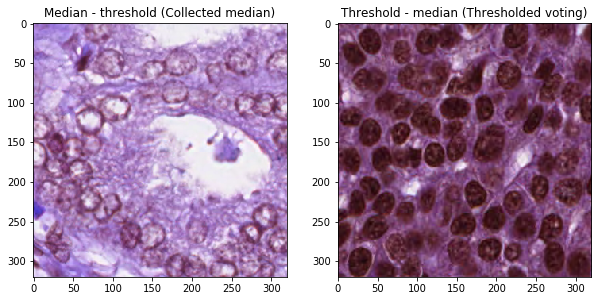

In [94]:
test_img_names = [f for f in os.listdir(TEST_IMG_PATH) if f.endswith('.tif')]

fig = plt.figure(figsize=(10,5))

img = cv2.imread(TEST_IMG_PATH + test_img_names[0])[:320, :320, :]
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img)
ax.title.set_text('Median - threshold (Collected median)')

img = cv2.imread(TEST_IMG_PATH + test_img_names[2])[:320, :320, :]
ax = fig.add_subplot(1, 2, 2)
plt.imshow(img)
ax.title.set_text('Threshold - median (Thresholded voting)')

In [93]:
print('Collected median (JI average) perfomed better by : ' + str((results_median['ji'].mean() - results['ji'].mean())*100) + '%')
print('Collected median (DICE average) perfomed better by : ' + str((results_median['dice'].mean() - results['dice'].mean())*100) + '%')


Collected median (JI average) perfomed better by : 0.1624911387881789%
Collected median (DICE average) perfomed better by : 0.11087708061158219%


### CONCLUSION

Collected median performs better in images with vesicular nuclei. Oterwise both, collected median and thresholded voting, have approximately the same performance. 

## IMPACT OF DIFFERENT STRIDE SIZES (1-128)

### TIME (img size 640:640)

Text(0, 0.5, 'time per image in s')

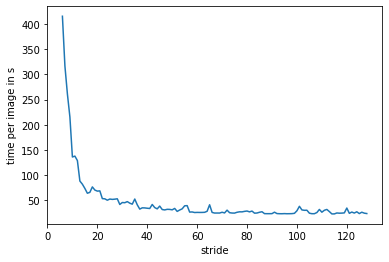

In [96]:
df = pd.read_csv(DUMPS_PATH + 'collected_output_median.csv', index_col=0)
plt.plot(df['stride'], df['time'])
plt.xlabel('stride')
plt.ylabel('time per image in s')

### COLLECTED MEAN for 3 different images with all strides 

Images were chosen as the best, worst and an average results from the previously used 10 training images for collected median and thresholded voting comparison. 

In [2]:
mean_results = pd.DataFrame(columns=['stride', 'time', 'ji', 'dice', 'img'])
img_names_chosen = [img_names[3], img_names[4], img_names[7]]
k = 0

for name in img_names_chosen:
    
    img = cv2.imread(TRAIN_IMG_PATH + name)[:320, :320, :]
    ground_truth = cv2.imread(TRAIN_MASK_PATH + name.rstrip('tif') + 'png', cv2.IMREAD_GRAYSCALE)[:320, :320]
    
    for i in range(128):
        stride = 128-i

        start_image = timer()
        result = collect_output(model, img, stride=stride)
        end_image = timer()

        mask = otsu_theshold(result)

        ji = metrics.jaccard_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))
        dice = metrics.f1_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))

        mean_results.loc[k] = [stride, end_image-start_image, ji, dice, name]
        k +=1
        if i%10==0:
            mean_results.to_csv(DUMPS_PATH + 'collected_output_mean.csv')

mean_results.to_csv(DUMPS_PATH + 'collected_output_mean.csv')

In [104]:
mean_results.head(10)

,stride,time,ji,dice,img
0,128,0.228988,0.750041,0.857170,TCGA-AR-A1AS-01Z-00-DX1.tif
1,127,0.249233,0.749590,0.856875,TCGA-AR-A1AS-01Z-00-DX1.tif
2,126,0.217601,0.747436,0.855466,TCGA-AR-A1AS-01Z-00-DX1.tif
3,125,0.228197,0.732437,0.845557,TCGA-AR-A1AS-01Z-00-DX1.tif
4,124,0.314010,0.746974,0.855163,TCGA-AR-A1AS-01Z-00-DX1.tif
5,123,0.235363,0.742219,0.852039,TCGA-AR-A1AS-01Z-00-DX1.tif
6,122,0.212831,0.742125,0.851977,TCGA-AR-A1AS-01Z-00-DX1.tif
7,121,0.217024,0.745879,0.854445,TCGA-AR-A1AS-01Z-00-DX1.tif
8,120,0.228833,0.764167,0.866320,TCGA-AR-A1AS-01Z-00-DX1.tif
9,119,0.215046,0.758203,0.862475,TCGA-AR-A1AS-01Z-00-DX1.tif


In [108]:
first_img = mean_results[mean_results['img']==mean_results['img'][0]]
first_img.shape

(128, 5)

#### Image with average JI

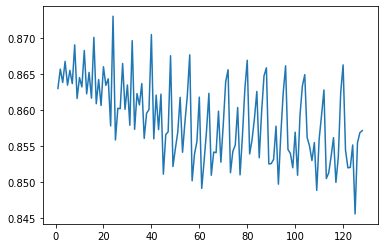

In [110]:
plt.plot(first_img['stride'], first_img['dice'])

#### Image with the best JI

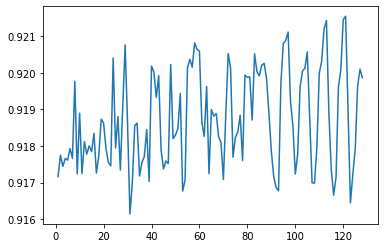

In [117]:
second_img = mean_results[mean_results['img']==mean_results['img'][128]]
plt.plot(second_img['stride'], second_img['dice'])

#### Image with the worst JI

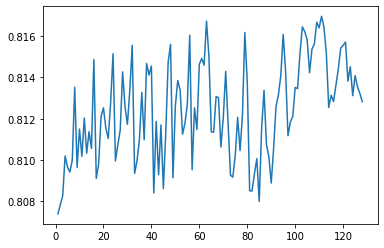

In [118]:
third_img = mean_results[mean_results['img']==mean_results['img'][256]]
plt.plot(third_img['stride'], third_img['dice'])

### Collected median for 2/3 test images (340:340)

In [3]:
results_median = pd.DataFrame(columns=['stride', 'time', 'ji', 'dice', 'img'])

k = 0 

for name in test_img_names:
    
    img = cv2.imread(TEST_IMG_PATH + name)[:320, :320, :]
    ground_truth = cv2.imread(TEST_MASK_PATH + name.rstrip('tif') + 'png', cv2.IMREAD_GRAYSCALE)[:320, :320]
    
    for i in range(0, 128):
        stride = 128-i

        start_image = timer()
        result = collect_output_median(model, img, stride=stride)
        end_image = timer()

        mask = otsu_theshold(result)

        ji = metrics.jaccard_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))
        dice = metrics.f1_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))

        results_median.loc[k] = [stride, end_image-start_image, ji, dice, name]
        k += 1
        
        if i%10==0 or stride<5:
            results_median.to_csv(DUMPS_PATH + 'collected_median_test_imgs.csv')

dump(results_median, 'collected_median_test_imgs', DUMPS_PATH, verbose=False)

In [7]:
results_median = pd.read_csv(DUMPS_PATH + 'collected_median_test_imgs.csv', index_col=0)

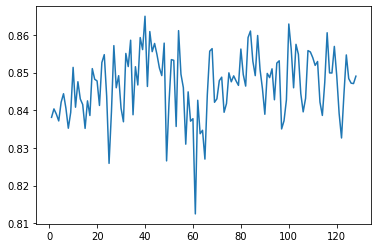

In [9]:
first_img = results_median[results_median['img']==results_median['img'][0]]
plt.plot(first_img['stride'], first_img['dice'])

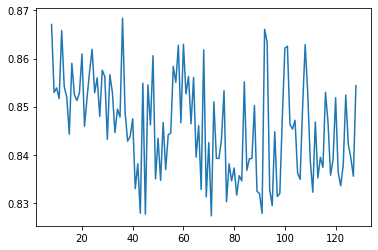

In [10]:
second_img = results_median[results_median['img']==results_median['img'][128]]
plt.plot(second_img['stride'], second_img['dice'])

### (Older) results with poor model prerformance and test image size 640:640, collected median

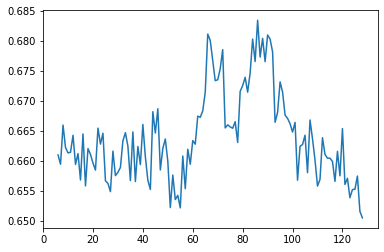

In [15]:
plt.plot(df['stride'], df['dice'])

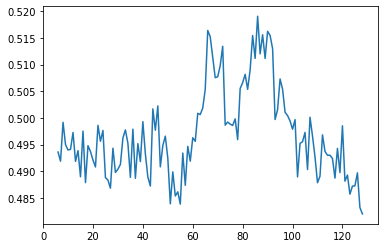

In [13]:
plt.plot(df['stride'], df['ji'])

### CONCLUSION

It seems like stride does not have the expected impact on the final result